<a href="https://colab.research.google.com/github/Ogunfool/Approximate-RL-Methods-for-CartPole-Environment-on-OpenAI-gym/blob/main/CartPole_Approximate_Montecarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Monte Carlo Gradient Ascent (SGD)
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler

GAMMA = 0.99
ALPHA = 0.1

def epsilon_greedy(model, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    values = model.predict_all_actions(s)
    return np.argmax(values)
  else:
    return model.env.action_space.sample()


def gather_samples(env, n_episodes=10000):
  samples = []
  for _ in range(n_episodes):
    s = env.reset()
    done = False
    truncated = False
    while not (done or truncated):
      a = env.action_space.sample()
      sa = np.concatenate((s, [a]))
      samples.append(sa)

      s, r, done, truncated = env.step(a)
  return samples

def play_one_episode(env, model):
  # Create lists for states, actions and rewards
  states = []
  rewards = [0]
  actions = []
  # Now play the game
  s = env.reset()
  episode_reward = 0
  done = False
  truncated = False
  while not (done or truncated):
    a = epsilon_greedy(model, s)
    s2, r, done, truncated = env.step(a)
    # Append to list
    states.append(s)
    rewards.append(r)
    actions.append(a)

    s =s2
  # print("States:", states, "Rewards:", rewards, "Actions:", actions)
  return states, rewards, actions

class Model:
  def __init__(self, env):
    # fit the featurizer to data
    self.env = env
    samples = gather_samples(env)
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x @ self.w

  def predict_all_actions(self, s):
    return [self.predict(s, a) for a in range(self.env.action_space.n)]

  def transform(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x


def test_agent(model, env, n_episodes=20):
  reward_per_episode = np.zeros(n_episodes)
  for it in range(n_episodes):
    done = False
    truncated = False
    episode_reward = 0
    s = env.reset()
    while not (done or truncated):
      a = epsilon_greedy(model, s, eps=0)
      s, r, done, truncated = env.step(a)
      episode_reward += r
    reward_per_episode[it] = episode_reward
  return np.mean(reward_per_episode)


def watch_agent(model, env, eps):
  done = False
  truncated = False
  episode_reward = 0
  s = env.reset()
  while not (done or truncated):
    a = epsilon_greedy(model, s, eps=eps)
    s, r, done, truncated = env.step(a)
    episode_reward += r
  print("Episode reward:", episode_reward)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode reward: 10.0
Episode: 50, Reward: 12.0
Episode: 100, Reward: 24.0
Episode: 150, Reward: 31.0
Episode: 200, Reward: 22.0
Episode: 250, Reward: 27.0
Episode: 300, Reward: 25.0
Episode: 350, Reward: 28.0
Episode: 400, Reward: 38.0
Episode: 450, Reward: 66.0
Episode: 500, Reward: 88.0
Episode: 550, Reward: 26.0
Episode: 600, Reward: 31.0
Episode: 650, Reward: 31.0
Episode: 700, Reward: 47.0
Episode: 750, Reward: 40.0
Episode: 800, Reward: 25.0
Episode: 850, Reward: 34.0
Episode: 900, Reward: 37.0
Episode: 950, Reward: 15.0
Episode: 1000, Reward: 15.0
Episode: 1050, Reward: 13.0
Episode: 1100, Reward: 17.0
Episode: 1150, Reward: 18.0
Episode: 1200, Reward: 23.0
Episode: 1250, Reward: 20.0
Episode: 1300, Reward: 20.0
Episode: 1350, Reward: 67.0
Episode: 1400, Reward: 46.0
Episode: 1450, Reward: 60.0
Episode: 1500, Reward: 29.0
Episode: 1550, Reward: 102.0
Episode: 1600, Reward: 65.0
Episode: 1650, Reward: 81.0
Episode: 1700, Reward: 79.0
Episode: 1750, Reward: 85.0
Episode: 1800, Rew

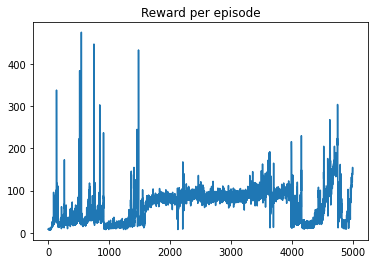

Episode reward: 142.0


In [2]:

# instantiate environment
# env = gym.make("CartPole-v1", render_mode="rgb_array")
env = gym.make("CartPole-v1")
model = Model(env)
reward_per_episode = []

# watch untrained agent
watch_agent(model, env, eps=0)

# repeat until convergence
n_episodes = 5000
for it in range(n_episodes):
  # Collect states, rewards and actions for a single episode 
  states, rewards, actions = play_one_episode(env, model) 

  G = 0
  T = len(states)
  episode_reward = 0
  for  t in range(T-2, -1, -1):
    s = states[t]
    r = rewards[t+1]
    a = actions[t]
    G = r + GAMMA*G # Smart Update rule (Did you see what I did there, HAHA)

    # Let's update Q(s,a) using approximate function
    # Constant learning rate since I don't use ample counts
    # update the model
    g = model.transform(s, a)
    err = G - model.predict(s, a)
    model.w += ALPHA * err * g
    
    # accumulate reward
    episode_reward += r

  if (it + 1) % 50 == 0:
    print(f"Episode: {it + 1}, Reward: {episode_reward}")

  # early exit
  if it > 20 and np.mean(reward_per_episode[-20:]) == 200:
    print("Early exit")
    break
  
  reward_per_episode.append(episode_reward)

# test trained agent
test_reward = test_agent(model, env)
print(f"Average test reward: {test_reward}")

plt.plot(reward_per_episode)
plt.title("Reward per episode")
plt.show()

# watch trained agent
# env = gym.make("CartPole-v1", render_mode="human")
watch_agent(model, env, eps=0)


Some tests..

In [ ]:
a = model.predict(s,a)

In [ ]:
def play_one_episode(env, model):
  # Create lists for states, actions and rewards
  states = []
  rewards = [0]
  actions = []
  # Now play the game
  s = env.reset()
  episode_reward = 0
  done = False
  truncated = False
  while not (done or truncated):
    a = epsilon_greedy(model, s)
    s2, r, done, truncated = env.step(a)
    # Append to list
    states.append(s)
    rewards.append(r)
    actions.append(a)

    s =s2
  print("States:", states, "Rewards:", rewards, "Actions:", actions)
  return states, rewards, actions


In [ ]:
states, rewards, actions = play_one_episode(env, model)
len(states)